In [1]:
%load_ext autoreload
%autoreload 2
from sim.Environment import Environment
from sim.LoadBalancer import LoadBalancer
from sim.Source import Source, ArrivalSchedule, BatchedSource, ExponentialSource

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
sns.set()

/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Running simple simulation
- 10 servers fixed
- 14 arrivals per second
- time limit 10

In [8]:
stopTime = 12*60*60
env = Environment(stopTime=stopTime)

loadBalancer = LoadBalancer(nServers=10, environment=env)

requestTypes = [(0.5,1,0.1,10), (0.5,2,0.2,10)] #(prob, mu, sigma, cancelTime)
arrivalsPerSecond = 10
source = Source(arrivalsPerSecond, requestTypes, loadBalancer, env)

env.run(debug=False, showProgress=False)

Benefit of running the system: 174720.00416664412


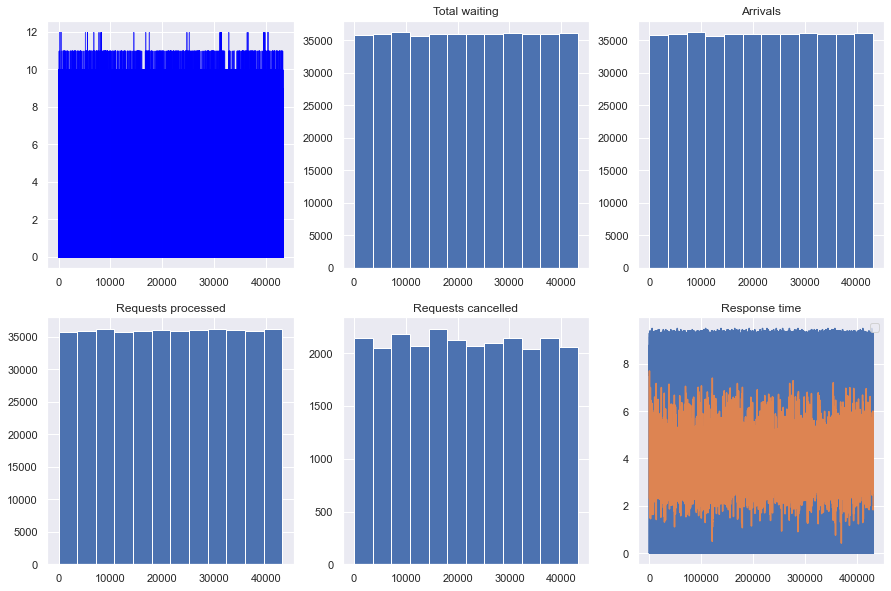

In [10]:
def plotSimulationSummary(environment: Environment, nServers=3):
    processCost = 1
    cancelCost = -10
    serverCost = -100

    nCancelled = len(environment.log['requestCancelled']) if 'requestCancelled' in environment.log.keys() else 0
    cost = len(environment.log['requestProcessed']) *processCost + nCancelled * cancelCost + nServers*env.currentTime/60/60*serverCost
    print(f"Benefit of running the system: {cost}")
    queueSizeKeys = [key for key in environment.log.keys() if 'queueSize' in key]

    fig, axs = plt.subplots(2,3, figsize=(15,10))
    axs_flat = axs.flatten()

    for key in queueSizeKeys:
         axs_flat[0].fill_between(environment.logTime[key], environment.log[key], alpha=0.7, color='blue')
        
    plt.legend(labels=[key.strip("queueSize_") for key in queueSizeKeys])

    axs_flat[1].hist(environment.logTime["requestStartWaiting"], bins=int(environment.stopTime/60/60))
    axs_flat[1].set_title("Total waiting")

    axs_flat[2].hist(environment.logTime["arrivalEvent"], bins=int(environment.stopTime/60/60))
    axs_flat[2].set_title("Arrivals")

    axs_flat[3].hist(environment.logTime["requestProcessed"], bins=int(environment.stopTime/60/60))
    axs_flat[3].set_title("Requests processed")

    if 'requestCancelled' in environment.log.keys():
        axs_flat[4].hist(environment.logTime["requestCancelled"], bins=int(environment.stopTime/60/60))
        axs_flat[4].set_title("Requests cancelled")

    axs_flat[5].plot(environment.log["requestWaitingTime"])
    rolling = pd.Series(index=environment.logTime["requestWaitingTime"], data=environment.log["requestWaitingTime"]).rolling(100).mean()
    axs_flat[5].plot(rolling.values)
    axs_flat[5].set_title("Response time")

plotSimulationSummary(environment=env)


In [54]:
#test source using exponential interarrival times
stopTime = 10*60*60
env = Environment(stopTime=stopTime)

loadBalancer = LoadBalancer(nServers=10, environment=env)

requestTypes = [(0.5,1,0.1,10), (0.5,2,0.2,10)] #(prob, mu, sigma, cancelTime)
arrivalsPerSecond = 14
source = ExponentialSource(arrivalsPerSecond, requestTypes, loadBalancer, env)

env.run(debug=False, showProgress=False)

Benefit of running the system: 244423.00030081955


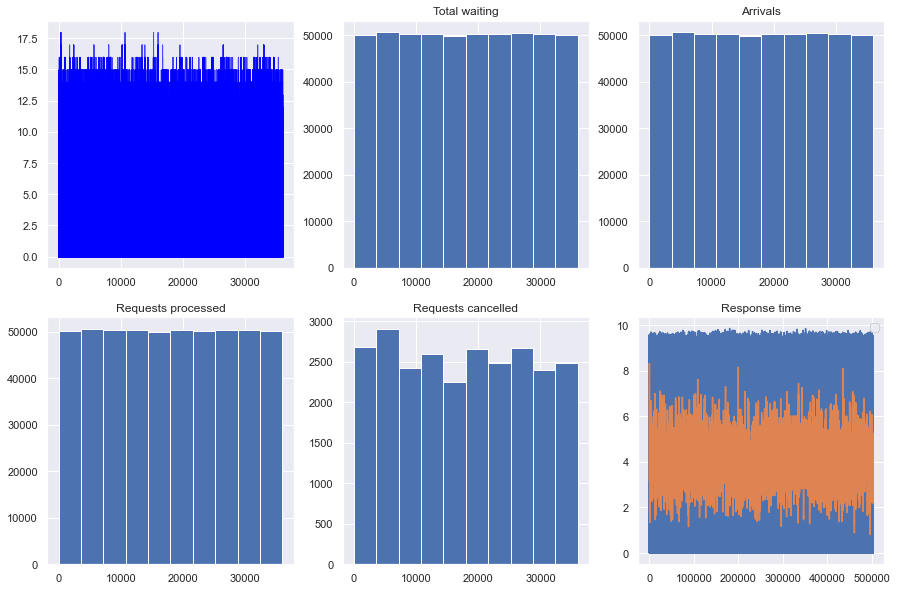

In [53]:
plotSimulationSummary(env)

In [55]:
env.log.keys()

dict_keys(['totalInQueue', 'requestStartWaiting', 'arrivalEvent', 'requestWaitingTime', 'queueSize_0', 'queueSize_1', 'queueSize_2', 'queueSize_3', 'queueSize_4', 'queueSize_5', 'queueSize_6', 'queueSize_7', 'queueSize_8', 'requestProcessed', 'totalTimeInSystem', 'queueSize_9', 'requestCancelled'])

In [35]:
stopTime = 1*60*60
env = Environment(stopTime=stopTime)

loadBalancer = LoadBalancer(nServers=10, environment=env)

requestTypes = [(0.5,1,0.1,10), (0.5,2,0.2,10)] #(prob, mu, sigma, cancelTime)
arrivalsPerSecond = 14
source = Source(arrivalsPerSecond, requestTypes, loadBalancer, env)

env.run(debug=False, showProgress=False)

## Time varying arrivals

In [29]:
stopTime = 12*60*60
env = Environment(stopTime=stopTime)

loadBalancer = LoadBalancer(nServers=3, environment=env)

requestTypes = [(0.5,1,0.1,10), (0.5,2,0.2,10)] #(prob, mu, sigma, cancelTime)
arrivalsPerSecond = 14
source = Source(arrivalsPerSecond, requestTypes, loadBalancer, env)

schedule = [11,12,14,16,14,12,13,15,17,16,14,12] #12 periods
periodLength = 0.5*60*60 #half an hour per period -> schedule repeated two times in 12 hours
arrivalSchedule = ArrivalSchedule(periodLength,arrivalSchedule=schedule, environment=env, loadBalancer=loadBalancer, source=source)
env.run(debug=False)

Benefit of running the system: -259087.0
total arrivals 596867
avg response time 4.808674360394396


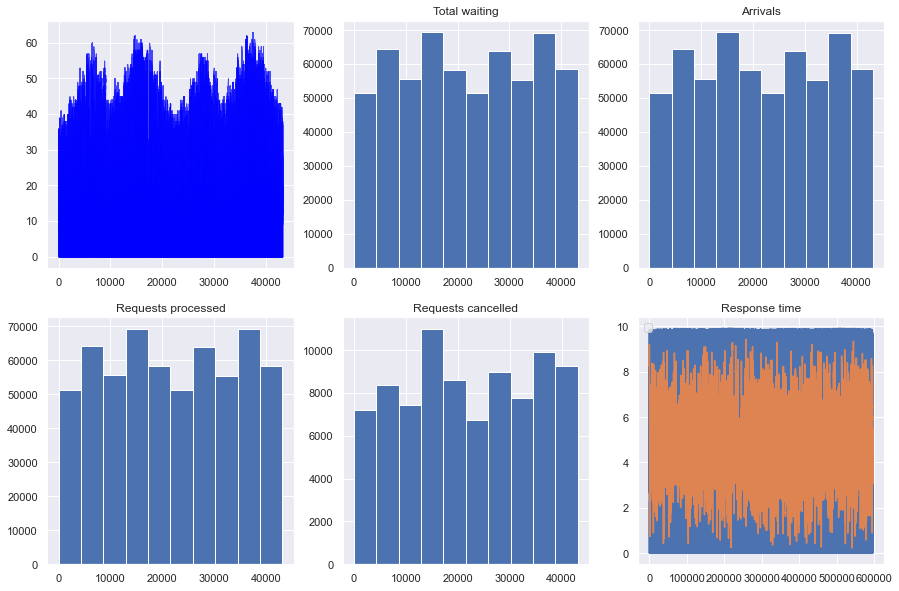

In [26]:
plotSimulationSummary(environment=env)
print("total arrivals", np.sum(env.log["arrivalEvent"]))
print("avg response time", np.mean(env.log["requestWaitingTime"]))

### with batched request generation

In [12]:
stopTime = 12*60*60
env = Environment(stopTime=stopTime)
periodLength = 0.5*60*60 #half an hour per period -> schedule repeated two times in 12 hours

loadBalancer = LoadBalancer(nServers=3, environment=env)

requestTypes = [(0.5,1,0.1,10), (0.5,2,0.2,10)] #(prob, mu, sigma, cancelTime)
arrivalsPerSecond = 14
source = BatchedSource(arrivalsPerSecond, requestTypes, loadBalancer, env, periodLength )

schedule = [11,12,14,16,14,12,13,15,17,16,14,12] #12 periods
arrivalSchedule = ArrivalSchedule(periodLength,arrivalSchedule=schedule, environment=env, loadBalancer=loadBalancer, source=source)
env.run(debug=False)

Benefit of running the system: -358570.0
total arrivals 575816
avg response time 4.653651668731482


/Users/julianvanmeggelen/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


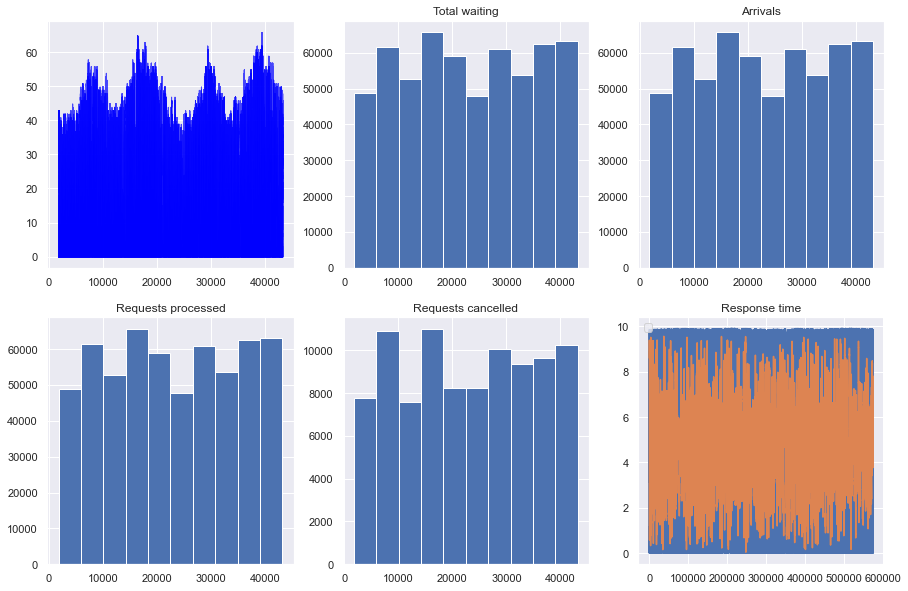

In [13]:
plotSimulationSummary(environment=env)
print("total arrivals", np.sum(env.log["arrivalEvent"]))
print("avg response time", np.mean(env.log["requestWaitingTime"]))

In [21]:
##ignore
stopTime = 3*60*60
samplingInterval = 0.05
profit = []
requestTypes = [(0.5,1,0.1,10), (0.5,2,0.2,10)] #(prob, mu, sigma, cancelTime)
processCost = 1
cancelCost = -10
serverCost = -300
arrivalProb = 0.5
1/samplingInterval * arrivalProb = arrivalsPerSecond/(1/samplingInterval)
nServers = range(10,40)
for n in nServers:
    env = Environment(stopTime=stopTime)
    loadBalancer = LoadBalancer(nServers=n, environment=env)
    source = Source(samplingInterval, arrivalProb, requestTypes, loadBalancer, env)
    env.run(debug=False)
    nCancelled = len(env.log['requestCancelled']) if 'requestCancelled' in env.log.keys() else 0
    cost = len(env.log['requestProcessed']) * processCost + nCancelled * cancelCost + stopTime/60/60*n*serverCost
    profit.append(cost)


plt.plot(nServers, profit)

SyntaxError: cannot assign to operator (<ipython-input-21-b7550743b1fc>, line 10)

In [ ]:
def binaryServerSearch(arrivalRate=0.5, searchSpace=[0,20], processCost = 1, cancelCost = -10, serverCost = -300, requestTypes = [(0.5,1,0.1,10), (0.5,2,0.2,10)]):
    

In [15]:
60*60/0.05

72000.0